In [1]:
!pip install tensorly

     |████████████████████████████████| 112kB 2.7MB/s 
     |████████████████████████████████| 163kB 8.2MB/s 
  Created wheel for tensorly: filename=tensorly-0.5.0-cp36-none-any.whl size=143028 sha256=ec7f177c67b91f5b7ca8893295f99eb29a5325064b53003d41af33eb0aac2bac
  Stored in directory: /root/.cache/pip/wheels/29/54/bc/46d12f7739ad709844b21801e3a91127bc91002111448e3572
Successfully built tensorly


In [2]:
import torch
import numpy as np
from torch import nn
import tensorly as tl
from tqdm import tqdm
import matplotlib.pyplot
from torch.optim import Adam
from torch.utils.data import DataLoader

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm.notebook import tqdm

import tensorly as tl
from tensorly.random import random_tucker
from tensorly.tucker_tensor import tucker_to_tensor


from torch.utils.data import Dataset

#tl.set_backend('pytorch')


class NeuralTensorLayer(torch.nn.Module):
    
    """
    This is the class for 
    """
    
    def __init__(self, order, input_dim, output_dim, rank_tucker=-1,
                 initializer=torch.nn.init.xavier_uniform):
        
        super(NeuralTensorLayer, self).__init__()
        
        self.order = order
        self.rank_tucker = rank_tucker
        
        if order > 3 or order < 1:
            raise Exception('Order must be in range [1, 3]')
            
        if rank_tucker != -1 and rank_tucker < 1:
            raise Exception('Tucker rank must be -1 or greater than 0 integer')
            
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.bias = nn.Parameter(torch.zeros((1, output_dim)), requires_grad=True)
        initializer(self.bias)
        
        self.myparameters = torch.nn.ParameterList([self.bias])
        
        self.order1_tens = self.initialize_n_order_tensor(1, initializer)
        
        if order >= 2:
            self.order2_tens = self.initialize_n_order_tensor(2, initializer)
            
        if order == 3:
            self.order3_tens = self.initialize_n_order_tensor(3, initializer)
        
    # initialize tensor in full or in decomposed form and register it as parameter
    def initialize_n_order_tensor(self, order, initializer):
        
        if self.rank_tucker >= 1:
            
            dim_list = [self.input_dim] * order + [self.output_dim]
            tens_core, factors = random_tucker(dim_list, self.rank_tucker)
            tens_core = nn.Parameter(tens_core, requires_grad=True)
            factors = [nn.Parameter(fact, requires_grad=True) for fact in factors]
            
            self.myparameters.append(tens_core)
            for fact in factors:
                self.myparameters.append(fact)
                
            return (tens_core, factors)
            
        else:
            
            dim_list = [self.input_dim] * order + [self.output_dim]
            var = nn.Parameter(torch.zeros(dim_list), requires_grad=True)
            initializer(var)
            self.myparameters.append(var)
            
            return var

    def compute_result_for_vec(self, core, factor_inp, last_factor): # result dim (1, 1)
        result = core
        for i in range(len(factor_inp)):
            result = tl.tenalg.mode_dot(result, factor_inp[i], i)
        result = result.view(1, -1).mm(torch.transpose(last_factor, 0, 1))
        return result.view(-1)

    def mode_n_dot_accelerated(self, core, factors, input):

        new_factors = [torch.transpose(factors[i], 0, 1).mm(input) for i in range(len(factors) - 1)]

        return torch.stack([
                            self.compute_result_for_vec(core, 
                                                        [new_factors[k][:, i] for k in range(len(factors) - 1)], factors[-1]) 
                            for i in range(input.shape[1])
                            ], dim=0)
        
    def forward(self, X, transposed=False):
        
        #X = torch.Tensor(X)
        
        if self.rank_tucker == -1:
            result = torch.addmm(self.bias, X, self.order1_tens)
        else:
            result = torch.addmm(self.bias, X, tucker_to_tensor(self.order1_tens))
        
        if self.order >= 2:
            
            if self.rank_tucker == -1:      
                acc = tl.tenalg.mode_dot(self.order2_tens, X, 0)
            else:
                acc = tl.tenalg.mode_dot(tucker_to_tensor(self.order2_tens), X, 0)

            acc = tl.tenalg.mode_dot(acc, X, 1)
            result += torch.einsum('iik->ik', acc)
        
        if self.order == 3:
             
            if self.rank_tucker == -1:      
                acc = tl.tenalg.mode_dot(self.order3_tens, X, 0)
            else:
                acc = tl.tenalg.mode_dot(tucker_to_tensor(self.order3_tens), X, 0)
            
            acc = tl.tenalg.mode_dot(acc, X, 1)
            acc = tl.tenalg.mode_dot(acc, X, 2)
            result += torch.einsum('iiik->ik', acc)
        
        return tl.reshape(result, (X.shape[0], self.output_dim))

    def get_orthogonality_loss(self):

        if self.rank_tucker == -1:
            return 0

        loss = 0

        for fact in self.order1_tens[1]:
            loss += torch.sum((tl.dot(fact.T, fact) - torch.eye(fact.shape[1]).cuda()) ** 2)
        
        if self.order >= 2:
            
            for fact in self.order2_tens[1]:
                loss += torch.sum((tl.dot(fact.T, fact) - torch.eye(fact.shape[1]).cuda()) ** 2)
        
        if self.order == 3:
             
            for fact in self.order3_tens[1]:
                loss += torch.sum((tl.dot(fact.T, fact) - torch.eye(fact.shape[1]).cuda()) ** 2)

        return loss


class MOA_set(Dataset):
    
    def __init__(self, fn_X, fn_Y=None, cuda=True):
        self.X = np.load(fn_X)
        self.Y = None if not fn_Y else np.load(fn_Y)
        self.Yn = True if not fn_Y else False
        self.cuda = cuda
        
    def __len__(self):
        return(self.X.shape[0])
    
    def __getitem__(self, ind):
        x = torch.from_numpy(self.X[ind]).type(torch.FloatTensor)
        if self.cuda:
            x = x.cuda()
        if not self.Yn:
            y = torch.from_numpy(self.Y[ind]).type(torch.FloatTensor)
            if self.cuda:
                y = y.cuda()
            return x, y
        else:
            return x

In [31]:
tl.set_backend('pytorch')

In [32]:
working_dir = '/content/drive/My Drive/study/Skoltech/MTF/Project'
data_dir = working_dir + '/data/'

In [33]:
train_set = MOA_set(data_dir + "train_X.npy", data_dir + "train_Y.npy")
val_set = MOA_set(data_dir + "val_X.npy", data_dir + "val_Y.npy")
test_set = MOA_set(data_dir + "testing_X.npy")

In [34]:
len(train_set), len(val_set), len(test_set)

(17860, 5954, 3982)

In [35]:
#train_set_X = torch.from_numpy(np.load(data_dir + "train_X.npy")).type(torch.FloatTensor).cuda()
#train_set_Y = torch.from_numpy(np.load(data_dir + "train_Y.npy")).type(torch.FloatTensor).cuda()
#train_dataset = torch.utils.data.TensorDataset(train_set_X, train_set_Y)

#val_set_X = torch.from_numpy(np.load(data_dir + "val_X.npy")).type(torch.FloatTensor).cuda()
#val_set_Y = torch.from_numpy(np.load(data_dir + "val_Y.npy")).type(torch.FloatTensor).cuda()
#val_dataset = torch.utils.data.TensorDataset(val_set_X, val_set_Y)

#test_set_X = torch.from_numpy(np.load(data_dir + "testing_X.npy")).type(torch.FloatTensor).cuda()
#test_dataset = torch.utils.data.TensorDataset(test_set_X)

In [36]:
BATCH_SIZE = 32

In [37]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [38]:
class TensorNet(nn.Module): 
    
    def __init__(self, order, input_dim, tensor_dim, output_dim, rank_tucker=5):
        super(TensorNet, self).__init__()
        self.tensor = NeuralTensorLayer(
            order, input_dim, tensor_dim, rank_tucker=rank_tucker
        )
        self.bn = nn.BatchNorm1d(tensor_dim)
        self.l = nn.Linear(tensor_dim, output_dim)
        self.s = nn.Sigmoid()
        
    def forward(self, x):
        return self.s(self.l(self.bn(self.tensor(x))))
    
    def predict(self, loader, train=True, verbose=False):
        Y_hat = []
        ld = tqdm(loader) if verbose else loader
        for a in ld:
            d = a[0] if train else a
            c_y_hat = self.forward(d).cpu().data.numpy()
            Y_hat.append(c_y_hat)
        return np.concatenate(Y_hat)
    
    def fit(self, loader, loss, optimizer, n_iter, val_loader, metrics, print_every=100, fit_orthogonal=False, orth_alpha=0):
        history = {a: [] for a in metrics}
        history["loss"] = []
        for i in tqdm(np.arange(n_iter)):
            mean_loss = 0
            self.train()
            for i,(batch_X, batch_Y) in enumerate(loader):
                optimizer.zero_grad()
                Y_hat = self.forward(batch_X)
                loss_val = loss(Y_hat, batch_Y)
                if fit_orthogonal:
                    loss_val += self.tensor.get_orthogonality_loss() * orth_alpha
                loss_val.backward()
                optimizer.step()
                mean_loss += loss_val.cpu().data.numpy()
            history["loss"].append(mean_loss/i)
            self.eval()
            val_Y_hat = self.predict(val_loader)
            val_Y = np.concatenate([a[1].cpu().data.numpy() for a in val_loader])
            for m in metrics:
                history[m].append(metrics[m](val_Y, val_Y_hat))
        return history

In [39]:
model = TensorNet(2, 879, 300, 206).cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [40]:
loss = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [41]:
def frobenius(Y, Y_hat):
    return tl.norm(torch.Tensor(Y) - torch.Tensor(Y_hat), 2)

def colwize_logloss_train(Y, Y_hat):
    summ = 0
    for i in range(Y.shape[1]):
        summ += loss(Y[:, i], Y_hat[:, i])
    return summ / Y.shape[1]

def colwize_logloss_eval(Y, Y_hat):
    return (Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat)).mean()

In [42]:
history = model.fit(train_loader, colwize_logloss_train, optimizer, 5, val_loader, 
                    {"F": frobenius, "mean_cw_loss": colwize_logloss_eval}, fit_orthogonal=True, orth_alpha=0.1)

In [25]:
np.load(data_dir + "val_X.npy").shape

(5954, 879)

In [26]:
history

{'F': [tensor(62.2898),
  tensor(62.1905),
  tensor(62.7790),
  tensor(62.2607),
  tensor(61.9622)],
 'loss': [0.05996820341468552,
  0.020249347194134654,
  0.020147337915382504,
  0.02017999151020601,
  0.02020160749381054],
 'mean_cw_loss': [-0.01998721,
  -0.019713264,
  -0.019858759,
  -0.019690346,
  -0.019621376]}

<Figure size 1080x1080 with 0 Axes>

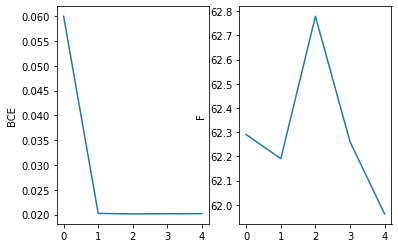

In [28]:
plt.figure(figsize=(15,15))
fig, axes = plt.subplots(1,2)
axes[0].plot(history["loss"])
axes[1].plot(history["F"])
axes[0].set_ylabel("BCE")
axes[1].set_ylabel("F")
plt.show()